In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/Deep Learning Project

/content/drive/MyDrive/Deep Learning Project


In [ ]:
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming Generator, Discriminator are in the models folder
from models import Generator, Discriminator

Load My Dataset

In [ ]:
# Load the dataset
dataset = load_dataset("dream-textures/textures-color-1k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


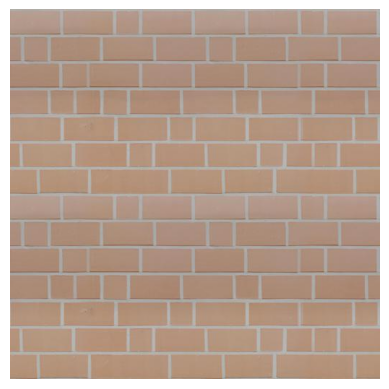

In [ ]:
# Access an image from the dataset
image = dataset['train'][42]['image']  # Access the first image in the training set

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

Data Preprocessing and Loader

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
from PIL import UnidentifiedImageError

class TextureDataset(Dataset):
    def __init__(self, split='train', transform=None):
        self.dataset = load_dataset("dream-textures/textures-color-1k", split=split)
        self.transform = transform
        self.valid_indices = self._find_valid_indices()

    def _find_valid_indices(self):
        valid_indices = []
        for i in range(len(self.dataset)):
            try:
                # Attempt to access and transform the image to identify any potential issues
                item = self.dataset[i]
                image = item['image']
                if self.transform:
                    image = self.transform(image)
                valid_indices.append(i)
            except UnidentifiedImageError:
                print(f"Skipping index {i} due to UnidentifiedImageError.")
            except Exception as e:
                print(f"Skipping index {i} due to unexpected error: {e}")
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        item = self.dataset[actual_idx]
        image = item['image']
        if self.transform:
            image = self.transform(image)
        return image


In [ ]:
from torchvision.transforms import Lambda

# Define your transformations with an explicit conversion to RGB
transform = transforms.Compose([
    Lambda(lambda img: img.convert('RGB')),  # Ensure the image is in RGB format
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset and dataloader
train_dataset = TextureDataset(split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Skipping index 1024 due to UnidentifiedImageError.


Training

Define Hyperparameters, Optimizer and Loss

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from models.Generator import Generator
from models.Discriminator import Discriminator

# Assuming you have a dataset variable ready, e.g., from torchvision.datasets or a custom dataset

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

In [ ]:
import torch
import torch.nn as nn  # For defining the L1 and MSE loss functions
import torch.optim as optim  # For the optimizers
from torch.utils.data import DataLoader  # For loading your dataset
from torchvision.utils import save_image  # For saving images
from tqdm import tqdm  # For the progress bar in the training loop

# If you're using TensorBoard for logging
from torch.utils.tensorboard import SummaryWriter

# For any image transformations, and if you're using albumentations for the same
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For handling file paths
import os


# For the style_extractor, if you're using a pretrained ResNet model
from torchvision.models import resnet50, ResNet50_Weights

# Additional imports for device management and potentially other utilities
import torchvision  # Might be used for transforms if not exclusively using albumentations


In [ ]:
config = {
    'STYLE_LOSS_WEIGHT': 1.0,  # Example weight for style loss
    'L1_LOSS_WEIGHT': 100.0,  # Example weight for L1 loss, often used in GANs for image tasks
    # Add other configuration parameters as needed
}


Epoch [5/10]: 100%|██████████| 90/90 [00:23<00:00,  3.78it/s, D_loss=0, G_loss=1]


Models saved at epoch 5


Epoch [10/10]: 100%|██████████| 90/90 [00:22<00:00,  3.97it/s, D_loss=9.09e-13, G_loss=1]


Models saved at epoch 10


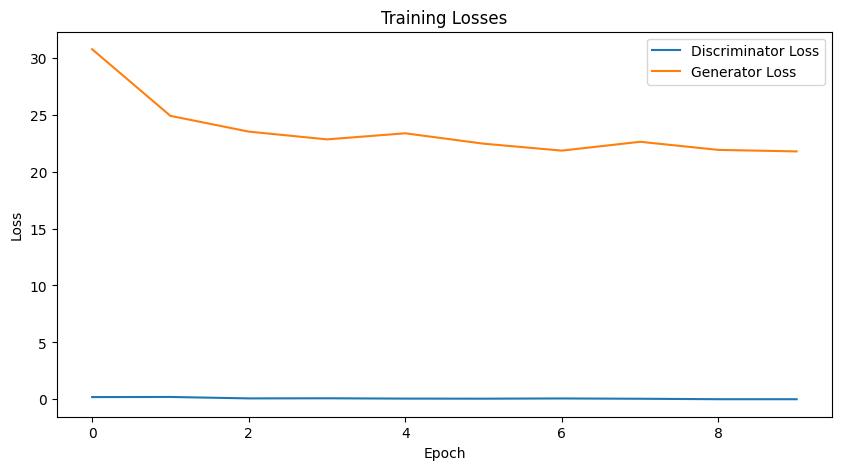

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

# Initialize gradient scalers
dScalar = GradScaler()
gScalar = GradScaler()

MODEL_SAVE_PATH = './models/checkpoints/'

num_epochs = 10
num_random_crops = 5

# Lists to store losses
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    # Temporary lists to store losses for each batch
    temp_d_losses = []
    temp_g_losses = []

    for i, images in loop:
        real_images = images.to(device)

        ### Train Discriminator
        optimizer_D.zero_grad()
        with autocast():
            fake_images = generator(real_images)
            real_output = discriminator(real_images)
            d_real_loss = F.mse_loss(real_output, torch.ones_like(real_output))
            fake_images = torchvision.transforms.CenterCrop(256)(fake_images)
            fake_output = discriminator(fake_images.detach())
            d_fake_loss = F.mse_loss(fake_output, torch.zeros_like(fake_output))
            d_loss = (d_real_loss + d_fake_loss)

        optimizer_D.zero_grad()
        dScalar.scale(d_loss).backward()
        dScalar.step(optimizer_D)
        dScalar.update()

        temp_d_losses.append(d_loss.item())

        ### Train Generator
        optimizer_G.zero_grad()
        with autocast():
            fake_output = discriminator(fake_images)
            g_loss = F.mse_loss(fake_output, torch.ones_like(fake_output))
            l1_loss = F.l1_loss(fake_images, real_images) * config['L1_LOSS_WEIGHT']
            g_final_loss = g_loss + l1_loss

        gScalar.scale(g_final_loss).backward()
        gScalar.step(optimizer_G)
        gScalar.update()

        temp_g_losses.append(g_final_loss.item())

        # Update the progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

    # Calculate average losses for the epoch and append to loss lists
    epoch_d_loss = sum(temp_d_losses) / len(temp_d_losses)
    epoch_g_loss = sum(temp_g_losses) / len(temp_g_losses)
    d_losses.append(epoch_d_loss)
    g_losses.append(epoch_g_loss)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(generator.state_dict(), MODEL_SAVE_PATH + f'generator_epoch_{epoch+1}.pth')
        torch.save(discriminator.state_dict(), MODEL_SAVE_PATH + f'discriminator_epoch_{epoch+1}.pth')
        print(f'Models saved at epoch {epoch+1}')

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


Generate 1 image

In [ ]:
model_path = './models/checkpoints/generator_epoch_10.pth'  # Adjust the path and filename as necessary
generator.load_state_dict(torch.load(model_path, map_location=device))
generator.to(device)
generator.eval()  # Set to evaluation mode

Generator(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
      (12): Conv2d(256, 100, kernel_size=(

In [ ]:
# Assuming the TextureDataset class is defined elsewhere in your code

# Step 1: Create the validation dataset and dataloader
validation_transform = transforms.Compose([
    Lambda(lambda img: img.convert('RGB')),  # Ensure the image is in RGB format
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

validation_dataset = TextureDataset(split='train', transform=validation_transform)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)  # Batch size set to 1

Skipping index 1024 due to UnidentifiedImageError.


In [ ]:
device

device(type='cuda')

In [ ]:
num_images = 5
validation_images = []
generated_images = []

# Accumulate images
with torch.no_grad():
    for i, images in enumerate(validation_loader):
        if i >= num_images: break  # Stop after getting num_images images
        img = images.to(device)
        validation_images.append(img)
        generated_images.append(generator(img))

In [ ]:
# Convert list of tensors to a single tensor
validation_images = torch.cat(validation_images, dim=0)
generated_images = torch.cat(generated_images, dim=0)

# Move images to CPU for plotting
validation_images = validation_images.cpu()
generated_images = generated_images.cpu()

In [ ]:
for i in range(num_images):
  validation_image_np = np.transpose(validation_images[i].numpy(), (1, 2, 0))
  generated_image_np = np.transpose(generated_images[i].numpy(), (1, 2, 0))
  print(validation_image_np.shape)
  print(generated_image_np.shape)
  break




(256, 256, 3)
(512, 512, 3)


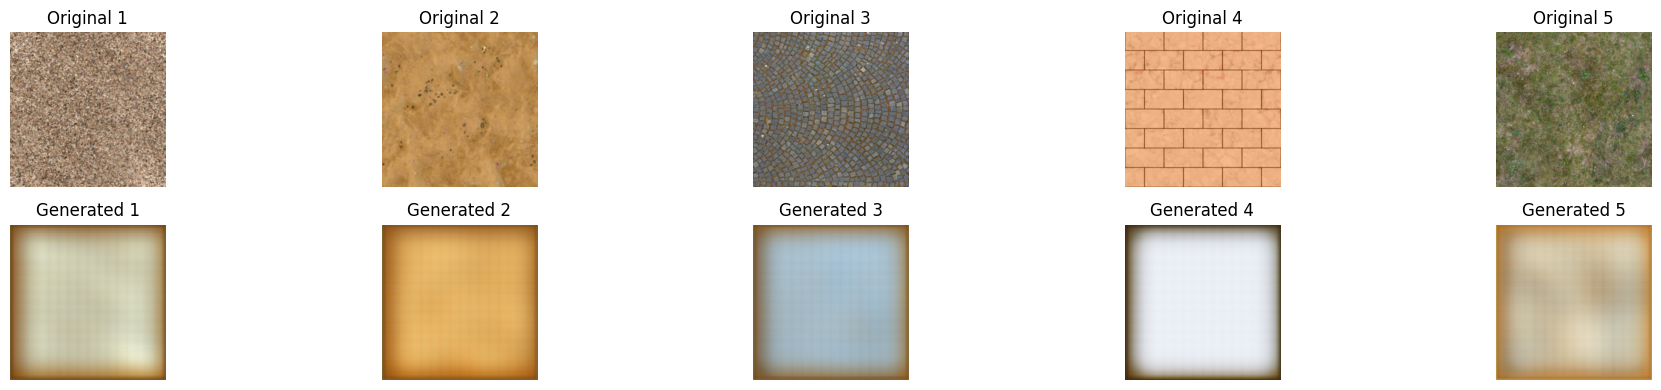

In [ ]:
# Create subplots
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))  # Adjust the figure size as needed

for i in range(num_images):
    # Original images
    validation_image_np = np.transpose(validation_images[i].numpy(), (1, 2, 0))
    validation_image_np = (validation_image_np - validation_image_np.min()) / (validation_image_np.max() - validation_image_np.min())
    axes[0, i].imshow(validation_image_np)
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')

    # Generated images
    generated_image_np = np.transpose(generated_images[i].numpy(), (1, 2, 0))
    generated_image_np = (generated_image_np - generated_image_np.min()) / (generated_image_np.max() - generated_image_np.min())
    axes[1, i].imshow(generated_image_np)
    axes[1, i].set_title(f'Generated {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()